# Figure 4

**Description:** Distribution and characteristics of putative polyA sites across the genome.

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_04")

os.makedirs(OUTDIR, exist_ok = True)
os.makedirs(os.path.join(os.path.dirname(RESDIR), 'site_density'), exist_ok = True)


## IMPORT DATA

In [5]:
included_features = ['intron:composite','intron:skipped','upstream_exon','terminal_exon','extended_terminal_exon']

try:
    with open(os.path.join(RESDIR, 'putative_sites.pickle'), mode = 'rb') as handle:
        putative_sites = pickle.load(handle)
        
except FileNotFoundError:
    
    putative_sites = pd.read_csv(os.path.join(RESDIR, "putative_cleavage_sites.annotated.with_predictions.txt"), sep = "\t")
    putative_sites = putative_sites.loc[putative_sites['feature'].isin(included_features) & (putative_sites['classification'] >= 0.5)].copy()

    with open(os.path.join(RESDIR, 'putative_sites.pickle'), mode = 'wb') as handle:
        pickle.dump(putative_sites, handle)
        

In [6]:
print(f"Putative sites: {len(putative_sites)}")
print(f"Putative genes: {putative_sites['feature_gene'].nunique()} ({len(putative_sites) / putative_sites['feature_gene'].nunique():.03f})")


Putative sites: 3591660
Putative genes: 32014 (112.190)


## Analyzing the distribution of genome-wide putative sites

#### Identifying expressed putative sites

In [7]:
putative_sites['cluster_slop_binary'] = (putative_sites['cluster_reads_slop'] >= 10).astype(int)
print(f"Expressed sites: {(putative_sites.cluster_reads_slop >= 10).sum()} ({(putative_sites.cluster_reads_slop >= 10).sum() / len(putative_sites):.02%})")
print(f"Expressed genes: {putative_sites.loc[putative_sites.cluster_slop_binary == True, 'feature_gene'].nunique()} ({(putative_sites.cluster_reads_slop >= 10).sum() / putative_sites.loc[putative_sites.cluster_slop_binary == True, 'feature_gene'].nunique():.03f})")


Expressed sites: 109193 (3.04%)
Expressed genes: 21642 (5.045)


#### Number of putative sites per feature

In [8]:
putative_sites_per_feature = (putative_sites['feature'].value_counts()
                              .loc[included_features]
                              .reset_index().rename(columns = {'index' : 'feature', 'feature' : 'count'})
                             )

putative_sites_per_feature['count_log10'] = np.log10(putative_sites_per_feature['count'])
putative_sites_per_feature['prop'] = putative_sites_per_feature['count'] / putative_sites_per_feature['count'].sum()
putative_sites_per_feature['label'] = putative_sites_per_feature['feature'] + " (" + (putative_sites_per_feature['prop']*100).round(2).astype(str) + "%)"


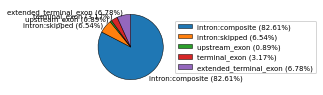

Corresponding data:


,feature,count,count_log10,prop,label
0,intron:composite,2967045,6.472324,0.826093,intron:composite (82.61%)
1,intron:skipped,235061,5.371181,0.065446,intron:skipped (6.54%)
2,upstream_exon,31960,4.504607,0.008898,upstream_exon (0.89%)
3,terminal_exon,113985,5.056848,0.031736,terminal_exon (3.17%)
4,extended_terminal_exon,243609,5.386693,0.067826,extended_terminal_exon (6.78%)


In [9]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

wedges, texts = plt.pie(putative_sites_per_feature['prop'], 
                        labels = putative_sites_per_feature['label'],
                        startangle = 90, counterclock = False, normalize = True,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, putative_sites_per_feature['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, 'percent_sites_in_feature.pie.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
putative_sites_per_feature


#### Number of expressed sites per feature

In [10]:
putative_sites_percent_expressed_by_feature = (putative_sites
                                               .groupby(['feature','cluster_slop_binary']).size()
                                               .loc[included_features]
                                               .reset_index().rename(columns = {0 : 'count'})
                                              )

putative_sites_percent_expressed_by_feature = putative_sites_percent_expressed_by_feature.loc[putative_sites_percent_expressed_by_feature['cluster_slop_binary'] == 1]
putative_sites_percent_expressed_by_feature['prop'] = putative_sites_percent_expressed_by_feature['count'] / putative_sites_percent_expressed_by_feature['count'].sum()
putative_sites_percent_expressed_by_feature['label'] = putative_sites_percent_expressed_by_feature['feature'] + " (" + (putative_sites_percent_expressed_by_feature['prop']*100).round(2).astype(str) + "%)"

putative_sites_percent_expressed_by_feature = putative_sites_percent_expressed_by_feature.set_index('feature').loc[putative_sites_per_feature['feature']]


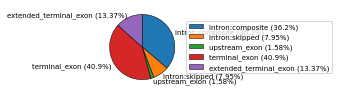

In [11]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

wedges, texts = plt.pie(putative_sites_percent_expressed_by_feature['prop'], 
                        labels = putative_sites_percent_expressed_by_feature['label'],
                        startangle = 90, counterclock = False, normalize = True,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, putative_sites_percent_expressed_by_feature['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, 'percent_sites_expressed_in_feature.pie.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Data summary

In [12]:
putative_sites_per_feature['category'] = 'putative_sites'
putative_sites_percent_expressed_by_feature['category'] = 'expressed_sites'

putative_sites_comb = (pd.concat([putative_sites_per_feature.reset_index()[['category','feature','prop']],
                                 putative_sites_percent_expressed_by_feature.reset_index()[['category','feature','prop']]
                                ], ignore_index = True, sort = False)
                      )

putative_sites_comb

,category,feature,prop
0,putative_sites,intron:composite,0.826093
1,putative_sites,intron:skipped,0.065446
2,putative_sites,upstream_exon,0.008898
3,putative_sites,terminal_exon,0.031736
4,putative_sites,extended_terminal_exon,0.067826
5,expressed_sites,intron:composite,0.362029
6,expressed_sites,intron:skipped,0.079529
7,expressed_sites,upstream_exon,0.015798
8,expressed_sites,terminal_exon,0.408991
9,expressed_sites,extended_terminal_exon,0.133653


## Visualize fraction of putative sites expressed

In [13]:
putative_sites_expressed = (putative_sites
                            .groupby(['feature','cluster_slop_binary']).size()
                            .loc[included_features]
                            .reset_index().rename(columns = {0 : 'count'})
                            )

putative_sites_expressed['prop'] = putative_sites_expressed['count'] / putative_sites_expressed.groupby('feature')['count'].transform('sum') * 100
putative_sites_expressed = putative_sites_expressed.loc[putative_sites_expressed['cluster_slop_binary'] == 1]
putative_sites_expressed['label'] = putative_sites_expressed['feature'] + " (" + (putative_sites_expressed['prop']).round(2).astype(str) + "%)"
putative_sites_expressed = putative_sites_expressed.set_index('feature').loc[putative_sites_expressed['feature']].reset_index()


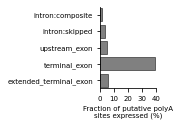

Corresponding data:
                  feature  cluster_slop_binary  count       prop  \
0  extended_terminal_exon                    1  14594   5.990747   
1        intron:composite                    1  39531   1.332336   
2          intron:skipped                    1   8684   3.694360   
3           terminal_exon                    1  44659  39.179717   
4           upstream_exon                    1   1725   5.397372   

                            label  
0  extended_terminal_exon (5.99%)  
1        intron:composite (1.33%)  
2          intron:skipped (3.69%)  
3          terminal_exon (39.18%)  
4            upstream_exon (5.4%)  


In [14]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

sns.barplot(data = putative_sites_expressed, 
            x = 'prop', y = 'feature', order = included_features,
            color = 'gray', edgecolor = 'black', linewidth = 0.5, ax = ax
           )

ax.set_xlim(0,40)
ax.xaxis.set_major_locator(MultipleLocator(10))

ax.set_xlabel("Fraction of putative polyA\nsites expressed (%)")
ax.set_ylabel("")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'percent_expressed_sites.vertical.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(putative_sites_expressed)


### Expressed Putative Site Usage by Feature

In [15]:
gene_counts = putative_sites['feature_gene'].value_counts()
gene_multiples = gene_counts[gene_counts >= 2].index
print(len(gene_multiples))


31658


In [16]:
print("\nGene multiples")
putative_exp = putative_sites.loc[putative_sites['feature_gene'].isin(gene_multiples) & (putative_sites['cluster_slop_binary'] == True) & (putative_sites['feature'].isin(included_features))]
print(putative_exp.shape)
print(putative_exp['feature'].value_counts())



Gene multiples
(109020, 38)
terminal_exon             44521
intron:composite          39526
extended_terminal_exon    14567
intron:skipped             8683
upstream_exon              1723
Name: feature, dtype: int64


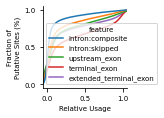

In [17]:
fig,ax = plt.subplots(1,1, figsize = (1.5, 1.5))

sns.kdeplot(data = putative_exp, 
            x = 'cluster_slop_score_denom', hue = 'feature', 
            hue_order = included_features,
            cumulative = True, common_norm = False, common_grid = False,
            ax = ax
           )

ax.set_xlim(-0.05,1.05)
ax.xaxis.set_major_locator(MultipleLocator(0.5))

ax.set_ylim(-0.05,1.05)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.set_xlabel("Relative Usage")
ax.set_ylabel("Fraction of\nPutative Sites (%)")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'05.supp.usage_by_feature.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


### Site Count and Density

#### Expression definition: 3'READS >= 10

In [18]:
convert_feature = {
    'terminal_exon' : 'TerminalExonic',
    'extended_terminal_exon' : 'ExtendedTerminalExonic',
    'intron:composite' : 'CompositeIntronic',
    'intron:skipped' : 'SkippedIntronic',
    'upstream_exon' : 'UpstreamExonic',
}

putative_sites['new_score'] = int(1)

putative_sites['new_feature'] = putative_sites['feature'].apply(lambda x : convert_feature[x])
print(putative_sites['new_feature'].value_counts())

putative_sites['new_label'] = "PolyaIDclassification_" + putative_sites['classification'].round(3).astype(str)
putative_sites['new_label'] = putative_sites['new_label'] + "|PolyaStrength_" + putative_sites['strength'].round(3).astype(str)
putative_sites['new_label'] = putative_sites['new_label'] + "|" + putative_sites['feature_gene']
putative_sites['new_label'] = putative_sites['new_label'] + "," + putative_sites['new_feature']

bed_cols = ['chrom', 'start', 'end', 'new_label', 'new_score', 'strand']

for s in ['+','-']:
    (putative_sites.loc[(putative_sites['strand'] == s), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.{s}.bed'), sep = "\t", index = False, header = False))


CompositeIntronic         2967045
ExtendedTerminalExonic     243609
SkippedIntronic            235061
TerminalExonic             113985
UpstreamExonic              31960
Name: new_feature, dtype: int64


In [19]:
putative_sites['new_label'] = putative_sites['feature_gene'] + "|" + putative_sites['feature']
putative_sites['new_label'] = putative_sites['new_label'] + "|polyaIDclassification_" + putative_sites['classification'].round(3).astype(str)
putative_sites['new_label'] = putative_sites['new_label'] + "|polyaIDcleavageprofile_" + putative_sites['score'].round(3).astype(str)

putative_sites['new_label'] = putative_sites['new_label'] + "|reads_" + putative_sites['cluster_reads_slop'].astype(str)
putative_sites['new_label'] = putative_sites['new_label'] + "|ru_" + putative_sites['cluster_slop_score_denom'].round(3).astype(str)

putative_sites['new_score'] = int(1)

expressed_sites = putative_sites.loc[putative_sites['cluster_slop_binary'] == 1].copy()

bed_cols      = ['chrom', 'start', 'end', 'new_label', 'new_score', 'strand']
bedgraph_cols = ['chrom', 'start', 'end', 'cluster_binprob']

for s in ['+','-']:
    
    (putative_sites.loc[(putative_sites['strand'] == s), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.{s}.bed'), sep = "\t", index = False, header = False))
    
    (putative_sites.loc[(putative_sites['strand'] == s), bedgraph_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.{s}.bedgraph'), sep = "\t", index = False, header = False))
             
    (expressed_sites.loc[(expressed_sites['strand'] == s), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'expressed_sites.{s}.bed'), sep = "\t", index = False, header = False))
    
    (expressed_sites.loc[(expressed_sites['strand'] == s), bedgraph_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'expressed_sites.{s}.bedgraph'), sep = "\t", index = False, header = False))
    
for f in included_features:
    
    (putative_sites.loc[(putative_sites['feature'] == f), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.{f.replace(":","_")}.bed'), sep = "\t", index = False, header = False))
             
    (expressed_sites.loc[(expressed_sites['feature'] == f), bed_cols]
     .to_csv(os.path.join(os.path.dirname(RESDIR), 'site_density', f'expressed_sites.{f.replace(":","_")}.bed'), sep = "\t", index = False, header = False))


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


#### Summarize sites per gene

In [20]:
print("# unique putative sites:\t\t", len(putative_sites))
print("# unique genes with putative sites:\t", putative_sites['feature_gene'].nunique())
print("# putative sites per gene overall:\t", len(putative_sites) / putative_sites['feature_gene'].nunique())

print("\n# unique expressed sites:\t\t", len(expressed_sites))
print("# unique genes with expressed sites:\t", expressed_sites['feature_gene'].nunique())
print("# expressed sites per gene overall:\t", len(expressed_sites) / expressed_sites['feature_gene'].nunique())


# unique putative sites:		 3591660
# unique genes with putative sites:	 32014
# putative sites per gene overall:	 112.19029174736053

# unique expressed sites:		 109193
# unique genes with expressed sites:	 21642
# expressed sites per gene overall:	 5.04542094076333


In [21]:
for f in included_features:
    print(f'\n#####\n{f}')
    
    putative_sites_f = putative_sites.loc[putative_sites['feature'] == f]
    expressed_sites_f = expressed_sites.loc[expressed_sites['feature'] == f]
    
    print("# unique putative sites:\t\t", len(putative_sites_f))
    print("# unique genes with putative sites:\t", putative_sites_f['feature_gene'].nunique())
    print("# putative sites per gene overall:\t", len(putative_sites_f) / putative_sites_f['feature_gene'].nunique())

    print("\n# unique expressed sites:\t\t", len(expressed_sites_f))
    print("# unique genes with expressed sites:\t", expressed_sites_f['feature_gene'].nunique())
    print("# expressed sites per gene overall:\t", len(expressed_sites_f) / expressed_sites_f['feature_gene'].nunique())
    


#####
intron:composite
# unique putative sites:		 2967045
# unique genes with putative sites:	 28157
# putative sites per gene overall:	 105.37503995454061

# unique expressed sites:		 39531
# unique genes with expressed sites:	 11789
# expressed sites per gene overall:	 3.3532106200695564

#####
intron:skipped
# unique putative sites:		 235061
# unique genes with putative sites:	 7157
# putative sites per gene overall:	 32.84350985049602

# unique expressed sites:		 8684
# unique genes with expressed sites:	 2774
# expressed sites per gene overall:	 3.1304974765681326

#####
upstream_exon
# unique putative sites:		 31960
# unique genes with putative sites:	 12237
# putative sites per gene overall:	 2.611751246220479

# unique expressed sites:		 1725
# unique genes with expressed sites:	 1277
# expressed sites per gene overall:	 1.350822239624119

#####
terminal_exon
# unique putative sites:		 113985
# unique genes with putative sites:	 25021
# putative sites per gene overall:	 4.5555

#### Summarize site density

In [22]:
site_counts = {}

for f in included_features:
    site_counts[f] = {'putative' : {}, 'expressed' : {}}


In [23]:
putative_site_counts = putative_sites['feature'].value_counts().loc[included_features].to_dict()

print("Putative sites by feature")
for k,v in putative_site_counts.items():
    print(f'{k:23} {v}')

for f in included_features: site_counts[f]['putative']['num_sites'] = putative_site_counts[f]


Putative sites by feature
intron:composite        2967045
intron:skipped          235061
upstream_exon           31960
terminal_exon           113985
extended_terminal_exon  243609


In [24]:
putative_site_genes = putative_sites.groupby('feature')['feature_gene'].nunique().loc[included_features].to_dict()

print("Genes containing putative sites by feature")
for k,v in putative_site_genes.items():
    print(f'{k:23} {v}')

for f in included_features: site_counts[f]['putative']['num_genes'] = putative_site_genes[f]


Genes containing putative sites by feature
intron:composite        28157
intron:skipped          7157
upstream_exon           12237
terminal_exon           25021
extended_terminal_exon  29006


In [25]:
expressed_site_counts = expressed_sites['feature'].value_counts().loc[included_features].to_dict()

print("Expressed sites by feature")
for k,v in expressed_site_counts.items():
    print(f'{k:23} {v}')

for f in included_features: site_counts[f]['expressed']['num_sites'] = expressed_site_counts[f]


Expressed sites by feature
intron:composite        39531
intron:skipped          8684
upstream_exon           1725
terminal_exon           44659
extended_terminal_exon  14594


In [26]:
expressed_site_genes = expressed_sites.groupby('feature')['feature_gene'].nunique().loc[included_features].to_dict()

print("Genes containing expressed sites by feature")
for k,v in expressed_site_genes.items():
    print(f'{k:23} {v}')

for f in included_features: site_counts[f]['expressed']['num_genes'] = expressed_site_genes[f]


Genes containing expressed sites by feature
intron:composite        11789
intron:skipped          2774
upstream_exon           1277
terminal_exon           16956
extended_terminal_exon  9474


In [27]:
#### RUN SITE DENSITY SCRIPT BEFORE THIS CELL

print("feature\t\t\tputative_bases\texpressed_bases")

for f in included_features:
    
    fsum_put = 0
    fsum_exp = 0
    
    fput_list = glob.glob(os.path.join(os.path.dirname(RESDIR), 'site_density', f'putative_sites.' + f.replace(":","_") + '.overlapping_*.merged.bed'))[0]
    fexp_list = glob.glob(os.path.join(os.path.dirname(RESDIR), 'site_density', f'expressed_sites.' + f.replace(":","_") + '.overlapping_*.merged.bed'))[0]

    with open(fput_list, mode = 'r') as handle:
        for line in handle:
            llist = line.strip().split("\t")
            fsum_put += (int(llist[2]) - int(llist[1]))
            
    with open(fexp_list, mode = 'r') as handle:
        for line in handle:
            llist = line.strip().split("\t")
            fsum_exp += (int(llist[2]) - int(llist[1]))
            
    if (len(f) < 16):
        print(f'{f}\t\t{fsum_put}\t{fsum_exp}')
    else:
        print(f'{f}\t{fsum_put}\t{fsum_exp}')
    
    site_counts[f]['putative']['occ_bases'] = fsum_put
    site_counts[f]['expressed']['occ_bases'] = fsum_exp


feature			putative_bases	expressed_bases
intron:composite	1458620756	533436068
intron:skipped		261856252	110801019
upstream_exon		12933826	2408671
terminal_exon		47708149	36867033
extended_terminal_exon	136938966	44503377


In [28]:
for f in included_features:
    
    site_counts[f]['putative']['sites_per_gene'] = site_counts[f]['putative']['num_sites'] / site_counts[f]['putative']['num_genes']
    site_counts[f]['putative']['sites_per_1kb']  = site_counts[f]['putative']['num_sites'] / site_counts[f]['putative']['occ_bases'] * 1000
    site_counts[f]['putative']['sites_per_10kb'] = site_counts[f]['putative']['num_sites'] / site_counts[f]['putative']['occ_bases'] * 10000
    
    site_counts[f]['expressed']['sites_per_gene'] = site_counts[f]['expressed']['num_sites'] / site_counts[f]['expressed']['num_genes']
    site_counts[f]['expressed']['sites_per_1kb']  = site_counts[f]['expressed']['num_sites'] / site_counts[f]['expressed']['occ_bases'] * 1000
    site_counts[f]['expressed']['sites_per_10kb'] = site_counts[f]['expressed']['num_sites'] / site_counts[f]['expressed']['occ_bases'] * 10000
    

In [29]:
values = ['num_sites','num_genes','sites_per_gene','occ_bases','sites_per_1kb','sites_per_10kb']

for fkey1,fdict1 in site_counts.items():
    print(f"\n#####\n{fkey1}")
    
    for fkey2,fdict2 in fdict1.items():
        print("\t", fkey2)
        
        for fkey3 in values:
            print(f"\t\t{fkey3}\t{fdict2[fkey3]:.03f}")
    


#####
intron:composite
	 putative
		num_sites	2967045.000
		num_genes	28157.000
		sites_per_gene	105.375
		occ_bases	1458620756.000
		sites_per_1kb	2.034
		sites_per_10kb	20.341
	 expressed
		num_sites	39531.000
		num_genes	11789.000
		sites_per_gene	3.353
		occ_bases	533436068.000
		sites_per_1kb	0.074
		sites_per_10kb	0.741

#####
intron:skipped
	 putative
		num_sites	235061.000
		num_genes	7157.000
		sites_per_gene	32.844
		occ_bases	261856252.000
		sites_per_1kb	0.898
		sites_per_10kb	8.977
	 expressed
		num_sites	8684.000
		num_genes	2774.000
		sites_per_gene	3.130
		occ_bases	110801019.000
		sites_per_1kb	0.078
		sites_per_10kb	0.784

#####
upstream_exon
	 putative
		num_sites	31960.000
		num_genes	12237.000
		sites_per_gene	2.612
		occ_bases	12933826.000
		sites_per_1kb	2.471
		sites_per_10kb	24.710
	 expressed
		num_sites	1725.000
		num_genes	1277.000
		sites_per_gene	1.351
		occ_bases	2408671.000
		sites_per_1kb	0.716
		sites_per_10kb	7.162

#####
terminal_exon
	 putative
		n

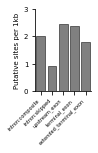

In [30]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

yvar = 'sites_per_1kb'
yfilt = 'putative'

ys = [site_counts[f][yfilt][yvar] for f in included_features]

sns.barplot(x = included_features, y = ys,
            order = included_features,
            color = 'gray', edgecolor = 'black',
            linewidth = 0.5, ax = ax
           )

ax.set_xticklabels(included_features, rotation = 45, ha = 'right', fontsize = 5)

ax.set_ylim(0,3)
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_ylabel(f'{yfilt.capitalize()} {yvar.replace("_", " ")}')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'site_density.{yfilt}.{yvar}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()



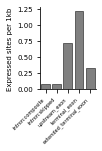

In [31]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

yvar = 'sites_per_1kb'
yfilt = 'expressed'

ys = [site_counts[f][yfilt][yvar] for f in included_features]

sns.barplot(x = included_features, y = ys,
            order = included_features,
            color = 'gray', edgecolor = 'black',
            linewidth = 0.5, ax = ax
           )

ax.set_xticklabels(included_features, rotation = 45, ha = 'right', fontsize = 5)

ax.set_ylim(0,None)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_ylabel(f'{yfilt.capitalize()} {yvar.replace("_", " ")}')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'site_density.{yfilt}.{yvar}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()

